In [1]:
import pandas as pd
import json
import glob

## Leitura dos dados

* 4 avaliadores
* 25 consultas com 6 documentos por avaliador (150 rótulos)
* 600 Rótulos no total, (com redundância) 
* Resultando em 300 pares consulta-documento rotulados

In [2]:
feedbacks = []
for name in glob.glob('./export*/*.json'):
    with open(name, "r") as feedback:
        feedbacks += json.load(feedback)
feedbacks = pd.DataFrame(feedbacks)

def change_corresponding(row):
    for elem in row["corresponding"]:
        elem["query"] = row["text"]
        elem["query_id"] = row["_id"]
    return row["corresponding"]
feedbacks["corresponding"] = feedbacks.apply(lambda row: change_corresponding(row) ,axis=1)

feedbacks = pd.json_normalize(feedbacks.explode("corresponding")["corresponding"])
feedbacks = feedbacks[feedbacks["labels"].apply(lambda x: bool(x))]
feedbacks["label"] = feedbacks["labels"].apply(lambda x: 1 if x[0]["label"]["name"] == "Relevante" else 0)
feedbacks["query"] = feedbacks["query"].apply(lambda x: x.replace("CONSULTA: ", ""))
feedbacks

,text,_id,labels,query,query_id,label
0,\n\nDocumento:20000110607\n\n\n\n\nPoder Judic...,72ie2H0BazwYFyie8dgm,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1
1,\n\nDocumento:20000006496\n\n\n\n\nPoder Judic...,B2eH2H0BazwYFyieir4V,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1
2,\n\nDocumento:20000085491\n\n\n\n\nPoder Judic...,J2if2H0BazwYFyiel-E3,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1
3,\n\nDocumento:20000020010\n\n\n\n\nPoder Judic...,rmmo2H0BazwYFyienEO8,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1
4,\n\nDocumento:20000006495\n\n\n\n\nPoder Judic...,BmeH2H0BazwYFyieir4V,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1
...,...,...,...,...,...,...
445,Capa do Processo Nº do Processo: 5005...,gGiV2H0BazwYFyieT2Sg,[{'label': {'id': '791b77df-7956-41b6-8442-5ec...,agentes políticos salário,1f8ece22-ca23-4805-bfa7-0e9d3fdabe6d,0
446,Capa do Processo Nº do Processo: 5038...,Emia2H0BazwYFyievaaa,[{'label': {'id': '791b77df-7956-41b6-8442-5ec...,agentes políticos salário,1f8ece22-ca23-4805-bfa7-0e9d3fdabe6d,0
447,\n\nDocumento:20000035467\n\n\n\n\nPoder Judic...,qWeF2H0BazwYFyieq6f_,[{'label': {'id': '791b77df-7956-41b6-8442-5ec...,agentes políticos salário,1f8ece22-ca23-4805-bfa7-0e9d3fdabe6d,0
448,Capa do Processo Nº do Processo: 5000...,LGZx2H0BazwYFyiehrs2,[{'label': {'id': '791b77df-7956-41b6-8442-5ec...,agentes políticos salário,1f8ece22-ca23-4805-bfa7-0e9d3fdabe6d,0


In [3]:
feedbacks[["text", "query", "label"]]

,text,query,label
0,\n\nDocumento:20000110607\n\n\n\n\nPoder Judic...,planos de saúde,1
1,\n\nDocumento:20000006496\n\n\n\n\nPoder Judic...,planos de saúde,1
2,\n\nDocumento:20000085491\n\n\n\n\nPoder Judic...,planos de saúde,1
3,\n\nDocumento:20000020010\n\n\n\n\nPoder Judic...,planos de saúde,1
4,\n\nDocumento:20000006495\n\n\n\n\nPoder Judic...,planos de saúde,1
...,...,...,...
445,Capa do Processo Nº do Processo: 5005...,agentes políticos salário,0
446,Capa do Processo Nº do Processo: 5038...,agentes políticos salário,0
447,\n\nDocumento:20000035467\n\n\n\n\nPoder Judic...,agentes políticos salário,0
448,Capa do Processo Nº do Processo: 5000...,agentes políticos salário,0


## Análise

In [4]:
scores = feedbacks.groupby(["_id", "query_id"])["label"].mean().to_frame()
scores["count"] = feedbacks.groupby(["_id", "query_id"])["label"].count()
scores

,,label,count
_id,query_id,,
-2d92H0BazwYFyieslD-,b4bb355d-e105-4b58-9bd1-c4421b89a058,1.0,1
-2id2H0BazwYFyiewsrT,40456087-473f-44f4-9aeb-6b8a61205c20,1.0,2
02Zt2H0BazwYFyiehJGF,a564b353-a905-4d5e-87d3-e50179a75e5c,0.0,1
02eE2H0BazwYFyie_Z-f,515c91af-935b-44a0-9034-2c067e06d796,0.0,1
0meK2H0BazwYFyieed7Q,a2f20a89-329a-4781-9ac3-80b3e1df8a93,1.0,2
...,...,...,...
zGmj2H0BazwYFyie5Q7v,d630e749-49cc-468e-a974-5f8cf9e609cc,1.0,1
zWeB2H0BazwYFyieX3dP,b4bb355d-e105-4b58-9bd1-c4421b89a058,1.0,1
zWid2H0BazwYFyielMjT,38ff53de-7e90-4dbb-b912-40a8c8c63de4,0.0,1


In [5]:
scores["label"].value_counts()

0.0    186
1.0     84
0.5     30
Name: label, dtype: int64

In [6]:
scores["count"].hist()

In [7]:
dataset = scores #need to save it here

### Apenas entradas com todos os rótulos

In [8]:
all_scores = scores[scores["count"] == 2]

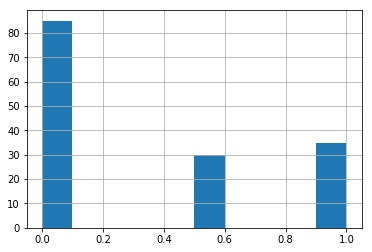

In [9]:
all_scores["label"].hist()

In [10]:
all_scores["label"].value_counts()

0.0    85
1.0    35
0.5    30
Name: label, dtype: int64

In [11]:
print("Observed agreement: ", 1 - (len([i for i in list(all_scores["label"]) if i == 0.5]) / len(all_scores)))

Observed agreement:  0.8


In [12]:
# consultas sem nenhum relevante

## Análise por modelo

In [13]:
original_feedbacks = []
with open("feedback_queries_final.json", "r") as feedback:
    original_feedbacks += json.load(feedback)
original_feedbacks = pd.DataFrame(original_feedbacks)

def change_corresponding(row):
    for elem in row["corresponding"]:
        elem["query"] = row["text"]
        elem["query_id"] = row["_id"]
    return row["corresponding"]
original_feedbacks["corresponding"] = original_feedbacks.apply(lambda row: change_corresponding(row) ,axis=1)

original_feedbacks = pd.json_normalize(original_feedbacks.explode("corresponding")["corresponding"])
original_feedbacks["query"] = original_feedbacks["query"].apply(lambda x: x.replace("CONSULTA: ", ""))
original_feedbacks = pd.merge(original_feedbacks[["query_id", "_id", "origin"]], feedbacks, on=["query_id", "_id"])
original_feedbacks

,query_id,_id,origin,text,labels,query,label
0,001404da-7082-4c96-8300-dd7836fb8f47,72ie2H0BazwYFyie8dgm,dense,\n\nDocumento:20000110607\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,1
1,001404da-7082-4c96-8300-dd7836fb8f47,72ie2H0BazwYFyie8dgm,dense,\n\nDocumento:20000110607\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,1
2,001404da-7082-4c96-8300-dd7836fb8f47,B2eH2H0BazwYFyieir4V,dense,\n\nDocumento:20000006496\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,1
3,001404da-7082-4c96-8300-dd7836fb8f47,B2eH2H0BazwYFyieir4V,dense,\n\nDocumento:20000006496\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,1
4,001404da-7082-4c96-8300-dd7836fb8f47,J2if2H0BazwYFyiel-E3,dirisparse,\n\nDocumento:20000085491\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,1
...,...,...,...,...,...,...,...
445,11fab1c0-d934-4084-bac5-3c67c1600f4e,U2eF2H0BazwYFyieVqRL,dense,\n\nDocumento:20000093124\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,transparência no processo licitatório,1
446,11fab1c0-d934-4084-bac5-3c67c1600f4e,smeB2H0BazwYFyiev3sU,dirisparse,\n\nDocumento:20000096246\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,transparência no processo licitatório,1
447,11fab1c0-d934-4084-bac5-3c67c1600f4e,XWie2H0BazwYFyieP9A6,dirisparse,\n\nDocumento:20000064218\n\n\n\n\nPoder Judic...,[{'label': {'id': '791b77df-7956-41b6-8442-5ec...,transparência no processo licitatório,0
448,11fab1c0-d934-4084-bac5-3c67c1600f4e,XGeH2H0BazwYFyieX7yh,bm25sparse,\n\nDocumento:20000003375\n\n\n\n\nPoder Judic...,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,transparência no processo licitatório,1


In [14]:
original_feedbacks.groupby("origin")["label"].mean().to_frame()

,label
origin,
bm25sparse,0.313333
dense,0.366667
dirisparse,0.313333


## Análise por avaliador

In [15]:
feedbacks["user"] = feedbacks["labels"].apply(lambda x: x[0]["user"]["name"])

In [16]:
feedbacks.groupby("user")["label"].mean().to_frame()

,label
user,
Elves Rodrigues,0.280000
Rafael Glater,0.406667
Rennan Cordeiro Lima,0.306667


# Inter-rater agreement


* Fleiss’s Kappa is an extension of Cohen’s kappa for three raters or more. In addition, the assumption with Cohen’s kappa is that your raters are deliberately chosen and fixed. With Fleiss’ kappa, the assumption is that your raters were chosen at random from a larger population.

* Kendall’s Tau is used when you have ranked data, like two people ordering 10 candidates from most preferred to least preferred.

* Krippendorff’s alpha is useful when you have multiple raters and multiple possible ratings.

### Kappas

In [17]:
scores = feedbacks.groupby(["_id", "query_id"])["label"].apply(list).to_frame()
scores["count"] = feedbacks.groupby(["_id", "query_id"])["label"].count()
all_scores = scores[scores["count"] == 2]

In [18]:
rater1 = [i[0] for i in list(all_scores["label"])]
rater2 = [i[1] for i in list(all_scores["label"])]

In [19]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(rater1, rater2)

0.5556872037914692

In [20]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/1400/1*mHB6Ciljb4OnOacNWgc0aw.png')

### Krippendorff

In [21]:
feedbacks["entry"] = feedbacks.apply(lambda row: row["_id"] + row["query_id"] ,axis=1)
feedbacks["user"] = feedbacks["labels"].apply(lambda x: x[0]["user"]["id"])
feedbacks.head(3)

,text,_id,labels,query,query_id,label,user,entry
0,\n\nDocumento:20000110607\n\n\n\n\nPoder Judic...,72ie2H0BazwYFyie8dgm,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1,01c719b5-ec9b-481a-b8a4-76e85867e599,72ie2H0BazwYFyie8dgm001404da-7082-4c96-8300-dd...
1,\n\nDocumento:20000006496\n\n\n\n\nPoder Judic...,B2eH2H0BazwYFyieir4V,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1,01c719b5-ec9b-481a-b8a4-76e85867e599,B2eH2H0BazwYFyieir4V001404da-7082-4c96-8300-dd...
2,\n\nDocumento:20000085491\n\n\n\n\nPoder Judic...,J2if2H0BazwYFyiel-E3,[{'label': {'id': '9e2e8d1f-46c7-452f-a202-f25...,planos de saúde,001404da-7082-4c96-8300-dd7836fb8f47,1,01c719b5-ec9b-481a-b8a4-76e85867e599,J2if2H0BazwYFyiel-E3001404da-7082-4c96-8300-dd...


In [22]:
import random
import numpy as np
import krippendorff
users_strings = {}

for user in feedbacks["user"].unique():
    users_strings[user] = []

for entry in feedbacks["entry"].unique():
    f = feedbacks[feedbacks["entry"] == entry]
    for user in feedbacks["user"].unique():
        if user in list(f["user"]):
            users_strings[user] += [f[f["user"] == user].iloc[0]["label"]]
        else:
            users_strings[user] += [np.nan]

reliability_data = list(users_strings.values())
np.array(reliability_data).dtype.kind
value = krippendorff.alpha(reliability_data=reliability_data, value_domain=[0, 1], level_of_measurement="nominal")
print("Krippendorff's alpha: ", value)

Krippendorff's alpha:  0.5515000000000001


The minimum acceptable alpha coefficient should be chosen according to the importance of the conclusions to be drawn from imperfect data. When the costs of mistaken conclusions are high, the minimum alpha needs to be set high as well. In the absence of knowledge of the risks of drawing false conclusions from unreliable data, social scientists commonly rely on data with reliabilities α ≥ 0.800, consider data with 0.800 > α ≥ 0.667 only to draw tentative conclusions, and discard data whose agreement measures α < 0.667

## Criação do dataset

In [23]:
dataset["final_label"] = dataset["label"].apply(lambda x: int(bool(x)))
dataset = dataset.reset_index()
dataset

,_id,query_id,label,count,final_label
0,-2d92H0BazwYFyieslD-,b4bb355d-e105-4b58-9bd1-c4421b89a058,1.0,1,1
1,-2id2H0BazwYFyiewsrT,40456087-473f-44f4-9aeb-6b8a61205c20,1.0,2,1
2,02Zt2H0BazwYFyiehJGF,a564b353-a905-4d5e-87d3-e50179a75e5c,0.0,1,0
3,02eE2H0BazwYFyie_Z-f,515c91af-935b-44a0-9034-2c067e06d796,0.0,1,0
4,0meK2H0BazwYFyieed7Q,a2f20a89-329a-4781-9ac3-80b3e1df8a93,1.0,2,1
...,...,...,...,...,...
295,zGmj2H0BazwYFyie5Q7v,d630e749-49cc-468e-a974-5f8cf9e609cc,1.0,1,1
296,zWeB2H0BazwYFyieX3dP,b4bb355d-e105-4b58-9bd1-c4421b89a058,1.0,1,1
297,zWid2H0BazwYFyielMjT,38ff53de-7e90-4dbb-b912-40a8c8c63de4,0.0,1,0
298,zWie2H0BazwYFyie8dkn,06b31304-b1bf-4d89-af61-d1d61904afe0,0.5,2,1


In [24]:
dataset = pd.merge(dataset, feedbacks,  left_on=['_id','query_id'], right_on = ['_id','query_id'])[['_id','query_id', "final_label","query", "text"]]
dataset = dataset.drop_duplicates()
dataset

,_id,query_id,final_label,query,text
0,-2d92H0BazwYFyieslD-,b4bb355d-e105-4b58-9bd1-c4421b89a058,1,título executivo extrajudicial prescrito,\n\nDocumento:20000034808\n\n\n\n\nPoder Judic...
1,-2id2H0BazwYFyiewsrT,40456087-473f-44f4-9aeb-6b8a61205c20,1,interesse recursal quanto ao pedido principal,\n\nDocumento:20000025597\n\n\n\n\nPoder Judic...
3,02Zt2H0BazwYFyiehJGF,a564b353-a905-4d5e-87d3-e50179a75e5c,0,crédito já habilitado,\n \n \n \n ...
4,02eE2H0BazwYFyie_Z-f,515c91af-935b-44a0-9034-2c067e06d796,0,prescrição acórdão confirmatório,\n\nDocumento:20000044815\n\n\n\n\nPoder Judic...
5,0meK2H0BazwYFyieed7Q,a2f20a89-329a-4781-9ac3-80b3e1df8a93,1,plano de partilha,\n\nDocumento:20000028348\n\n\n\n\nPoder Judic...
...,...,...,...,...,...
444,zGmj2H0BazwYFyie5Q7v,d630e749-49cc-468e-a974-5f8cf9e609cc,1,ação rescisória trabalhista,\n\nDocumento:20000087844\n\n\n\n\nPoder Judic...
445,zWeB2H0BazwYFyieX3dP,b4bb355d-e105-4b58-9bd1-c4421b89a058,1,título executivo extrajudicial prescrito,\n\nDocumento:20000035039\n\n\n\n\nPoder Judic...
446,zWid2H0BazwYFyielMjT,38ff53de-7e90-4dbb-b912-40a8c8c63de4,0,causalidade adequada,\n\nDocumento:20000098766\n\n\n\n\nPoder Judic...
447,zWie2H0BazwYFyie8dkn,06b31304-b1bf-4d89-af61-d1d61904afe0,1,padrão de vida do alimentando,\n\nDocumento:20000071783\n\n\n\n\nPoder Judic...


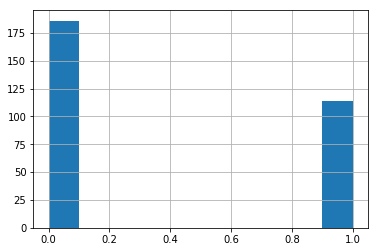

In [25]:
dataset["final_label"].hist()

## Pré Processamento

In [26]:
example = dataset["text"].iloc[0]
print(len(example))
print(example)

16644


Documento:20000034808




Poder Judiciário
TRIBUNAL REGIONAL FEDERAL DA 2ª REGIÃO






Agravo de Instrumento  Nº 5005172-73.2019.4.02.0000/RJ



AGRAVANTE: UNIÃO - ADVOCACIA GERAL DA UNIÃOAGRAVADO: FLAVIA PANETTI SANTOSADVOGADO: ALESSANDRO MEDEIROS (OAB DF042043)AGRAVADO: FRANCELLINA DO ROSARIO BRAUNSADVOGADO: ALESSANDRO MEDEIROS (OAB DF042043)AGRAVADO: FLAVIO CANTONE CORREA DE SAADVOGADO: ALESSANDRO MEDEIROS (OAB DF042043)


DESPACHO/DECISÃO


Trata-se de Agravo de Instrumento interposto pela UNIÃO - ADVOCACIA GERAL DA UNIÃO em face de FLAVIA PANETTI SANTOS, FLAVIO CANTONE CORREA DE SA e FRANCELLINA DO ROSARIO BRAUNS, com pedido de liminar, objetivando cassar a decisão proferida pelo Juízo da 18ª Vara Federal do Rio de Janeiro - Seção Judiciária do Rio de Janeiro, assim vertida:
"Trata-se de cumprimento de sentença coletiva proferida no processo nº 0002767-94.2001.4.01.3400.
O título executivo determinou aplicação à retribuição dos Técnicos do Tesouro Nacional - TTN o teto de

In [27]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    text = text.replace("\n", " ")
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    text = " ".join(filtered_sentence)
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text
    
print(len(clean_text(example)))
print(clean_text(example))

12793
Documento Poder Judiciário TRIBUNAL REGIONAL FEDERAL ª REGIÃO Agravo Instrumento Nº RJ AGRAVANTE  UNIÃO  ADVOCACIA GERAL UNIÃOAGRAVADO  FLAVIA PANETTI SANTOSADVOGADO  ALESSANDRO MEDEIROS  OAB DF  AGRAVADO  FRANCELLINA ROSARIO BRAUNSADVOGADO  ALESSANDRO MEDEIROS  OAB DF  AGRAVADO  FLAVIO CANTONE CORREA SAADVOGADO  ALESSANDRO MEDEIROS  OAB DF  DESPACHODECISÃO Tratase Agravo Instrumento interposto UNIÃO  ADVOCACIA GERAL UNIÃO face FLAVIA PANETTI SANTOS  FLAVIO CANTONE CORREA SA FRANCELLINA ROSARIO BRAUNS  pedido liminar  objetivando cassar decisão proferida Juízo ª Vara Federal Rio Janeiro  Seção Judiciária Rio Janeiro  assim vertida   Tratase cumprimento sentença coletiva proferida processo nº   título executivo determinou aplicação retribuição Técnicos Tesouro Nacional  TTN teto oito vezes valor maior vencimento própria categoria  termos art  º  MP   norma posteriormente convertida Lei   conforme anexo  Evento   Desse modo  condenou União pagamento  título atrasados  diferença van

## Treinamento e teste

In [28]:
!nvidia-smi

Tue Feb  1 10:31:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   30C    P0    35W / 250W |   2344MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [41]:
from tqdm import tqdm
from scipy import spatial
from sklearn.model_selection import KFold
from sentence_transformers import SentenceTransformer, util, losses, CrossEncoder, util, losses, InputExample, models
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

def report_result(ranking_cut, ndcg, recall, mrr, precision):
    print(f"% NDCG@{ranking_cut}: ",  np.mean(ndcg))
    print(f"% MRR: ",  np.mean(mrr))
    
def select_choosen_metrics(metrics_result, ranking_cut, queries_ids):
    ndcg = []
    for key in queries_ids:
        ndcg.append(metrics_result[key][f"ndcg_cut_{ranking_cut}"])

    recall = []
    for key in queries_ids:
        recall.append(metrics_result[key][f"recall_{ranking_cut}"])

    mrr = []
    for key in queries_ids:
        mrr.append(metrics_result[key]["recip_rank"])

    precision = []
    for key in queries_ids:
        precision.append(metrics_result[key][f"P_{ranking_cut}"])

    return ndcg, recall, mrr, precision

def statistic_relevance(first_results, second_results):
    import scipy

    query_ids = list(set(first_results.keys()) & set(second_results.keys()))

    first_scores = [
        first_results[query_id][f"ndcg_cut_{ranking_cut}"] for query_id in query_ids]
    second_scores = [
        second_results[query_id][f"ndcg_cut_{ranking_cut}"] for query_id in query_ids]

    print("\nStatistic Relevance for NDCG")
    print(scipy.stats.ttest_rel(first_scores, second_scores))

    first_scores = [
        first_results[query_id][f"recip_rank"] for query_id in query_ids]
    second_scores = [
        second_results[query_id][f"recip_rank"] for query_id in query_ids]

    first_scores = [i if i >= 0.1 else 0 for i in first_scores]
    second_scores = [i if i >= 0.1 else 0 for i in second_scores]

    print("\nStatistic Relevance for MRR")
    print(scipy.stats.ttest_rel(first_scores, second_scores))

def cross_encoder_score(model, query, text):
    sim = model.predict([query, text])
    return float(sim)

def bi_encoder_score(model, query, text):
    output = model.encode([query, text])
    sim = spatial.distance.cosine(output[0], output[1])
    return sim

def eval_model(dataset, scorer, model, ranking_cut=5):
    ranking = {}
    for idx, row in dataset.iterrows():
        if not row["query_id"] in ranking:
            ranking[row["query_id"]] = {}
        ranking[row["query_id"]][row["_id"]] = scorer(model, row["query"], clean_text(row["text"]))

    ranking_metrics = evaluator.evaluate(ranking)
    queries_ids = list(ranking_metrics.keys())
    return ranking_metrics, ranking_cut, queries_ids

def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = {}
        for inner_key in dict_list[0][key].keys():
            mean_dict[key][inner_key] = sum(d[key][inner_key] for d in dict_list) / len(dict_list)
    return mean_dict

In [42]:
import pytrec_eval
#load qrels

qrel = {}
for idx, row in dataset.iterrows():
    if not row["query_id"] in qrel:
        qrel[row["query_id"]] = {}
    qrel[row["query_id"]][row["_id"]] = row["final_label"]
    
evaluator = pytrec_eval.RelevanceEvaluator(qrel, {"recip_rank", 'ndcg_cut', "recall", "P"})

In [43]:
from random import random

### Baselines

#### Random Scores Evaluation

In [44]:
queries_set = set(dataset[dataset["final_label"] == 1]["query_id"])

In [45]:
random_metrics, ranking_cut, queries_ids = eval_model(dataset, lambda model, query, doc: random(), model=None)
results = select_choosen_metrics(random_metrics, ranking_cut, queries_set)
report_result(ranking_cut, *results)

% NDCG@5:  0.7488589163462326
% MRR:  0.7572916666666667


#### Same Scores Evaluation

In [46]:
same_score_metrics, ranking_cut, queries_ids = eval_model(dataset, lambda model, query, doc: 1, model=None)
results = select_choosen_metrics(same_score_metrics, ranking_cut, queries_set)
report_result(ranking_cut, *results)

% NDCG@5:  0.7178539115006042
% MRR:  0.7213541666666667


### Cross Encoder

#### Training

In [47]:
kf = KFold(n_splits=5)
kf.get_n_splits(dataset)
predictions = []
ground_truth = []
before_predictions = []
before_ground_truth = []
fine_tune_metrics_list = []
pretrained_metrics_list = []
for train_index, test_index in kf.split(dataset['query_id'].unique()):
    training_queries = dataset['query_id'].unique()[train_index]
    training = dataset[dataset['query_id'].isin(training_queries)]
    testing_queries = dataset['query_id'].unique()[test_index]
    testing = dataset[dataset['query_id'].isin(testing_queries)]

    sbert_model = []
    sbert_model = CrossEncoder('neuralmind/bert-base-portuguese-cased', max_length=300)
    examples = []
    for idx, row in tqdm(training.iterrows(), total=len(training)):
        examples.append(InputExample(texts=[row["query"], row["text"]], label=int(row["final_label"])))
    dataloader = DataLoader(examples, shuffle=True, batch_size=8)

    for idx, row in tqdm(testing.iterrows(), total=len(testing)):
        output = sbert_model.predict([row["query"], clean_text(row["text"])])
        before_predictions.append(output)
        before_ground_truth.append(row["final_label"])
        before_predictions = [1 if output > 0.5 else 0 for output in before_predictions]

    cross_pretrained_metrics, ranking_cut, queries_ids = eval_model(testing, cross_encoder_score, sbert_model)
    pretrained_metrics_list.append(cross_pretrained_metrics)

    sbert_model.fit(train_dataloader=dataloader, epochs=5, warmup_steps=100)
    
    fine_tune_metrics, ranking_cut, queries_ids = eval_model(testing, cross_encoder_score, sbert_model)
    fine_tune_metrics_list.append(fine_tune_metrics)
    
    for idx, row in tqdm(testing.iterrows(), total=len(testing)):
        output = sbert_model.predict([row["query"], clean_text(row["text"])])
        predictions.append(output)
        ground_truth.append(row["final_label"])
        predictions = [1 if output > 0.5 else 0 for output in predictions]
        
pretrained_metrics_list = dict(pair for d in pretrained_metrics_list for pair in d.items())
fine_tune_metrics_list = dict(pair for d in fine_tune_metrics_list for pair in d.items())


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the




  0%|          | 0/60 [00:00<?, ?it/s]


  2%|▏         | 1/60 [00:01<01:11,  1.22s/it]


  3%|▎         | 2/60 [00:02<01:10,  1.21s/it]


  5%|▌         | 3/60 [00:03<01:08,  1.20s/it]


  7%|▋         | 4/60 [00:04<01:07,  1.20s/it]


  8%|▊         | 5/60 [00:05<01:05,  1.20s/it]


 10%|█         | 6/60 [00:07<01:03,  1.18s/it]


 12%|█▏        | 7/60 [00:08<01:02,  1.18s/it]


 13%|█▎        | 8/60 [00:09<01:00,  1.17s/it]


 15%|█▌        | 9/60 [00:10<00:59,  1.17s/it]


 17%|█▋        | 10/60 [00:11<00:57,  1.16s/it]


 18%|█▊        | 11/60 [00:12<00:56,  1.15s/it]


 20%|██        | 12/60 [00:14<00:55,  1.16s/it]


 22%|██▏       | 13/60 [00:15<00:55,  1.17s/it]


 23%|██▎       | 14/60 [00:16<00:54,  1.18s/it]


 25%|██▌       | 15/60 [00:17<00:53,  1.18s/it]


 27%|██▋       | 16/60 [00:18<00:51,  1.18s/it]


 28%|██▊       | 17/60 [00:19<00:50,  1.18s/it]


 30%|███       | 18/60 [00:21<00:50,  1.19s/it]


 32%|███▏      | 19/60 [00:22<00:48,  1.19s/it]


 33%|███▎      




  0%|          | 0/60 [00:00<?, ?it/s]


  2%|▏         | 1/60 [00:01<01:08,  1.16s/it]


  3%|▎         | 2/60 [00:02<01:07,  1.17s/it]


  5%|▌         | 3/60 [00:03<01:06,  1.17s/it]


  7%|▋         | 4/60 [00:04<01:05,  1.17s/it]


  8%|▊         | 5/60 [00:05<01:04,  1.17s/it]


 10%|█         | 6/60 [00:07<01:03,  1.18s/it]


 12%|█▏        | 7/60 [00:08<01:03,  1.19s/it]


 13%|█▎        | 8/60 [00:09<01:01,  1.18s/it]


 15%|█▌        | 9/60 [00:10<01:00,  1.18s/it]


 17%|█▋        | 10/60 [00:11<00:58,  1.18s/it]


 18%|█▊        | 11/60 [00:12<00:57,  1.17s/it]


 20%|██        | 12/60 [00:14<00:55,  1.16s/it]


 22%|██▏       | 13/60 [00:15<00:54,  1.16s/it]


 23%|██▎       | 14/60 [00:16<00:53,  1.16s/it]


 25%|██▌       | 15/60 [00:17<00:52,  1.16s/it]


 27%|██▋       | 16/60 [00:18<00:51,  1.16s/it]


 28%|██▊       | 17/60 [00:19<00:49,  1.16s/it]


 30%|███       | 18/60 [00:21<00:48,  1.16s/it]


 32%|███▏      | 19/60 [00:22<00:47,  1.16s/it]


 33%|███▎      




  0%|          | 0/60 [00:00<?, ?it/s]


  2%|▏         | 1/60 [00:01<01:12,  1.23s/it]


  3%|▎         | 2/60 [00:02<01:10,  1.21s/it]


  5%|▌         | 3/60 [00:03<01:08,  1.20s/it]


  7%|▋         | 4/60 [00:04<01:06,  1.19s/it]


  8%|▊         | 5/60 [00:05<01:05,  1.19s/it]


 10%|█         | 6/60 [00:07<01:03,  1.18s/it]


 12%|█▏        | 7/60 [00:08<01:02,  1.17s/it]


 13%|█▎        | 8/60 [00:09<01:01,  1.18s/it]


 15%|█▌        | 9/60 [00:10<00:59,  1.16s/it]


 17%|█▋        | 10/60 [00:11<00:56,  1.13s/it]


 18%|█▊        | 11/60 [00:12<00:55,  1.14s/it]


 20%|██        | 12/60 [00:13<00:53,  1.12s/it]


 22%|██▏       | 13/60 [00:15<00:53,  1.14s/it]


 23%|██▎       | 14/60 [00:16<00:52,  1.14s/it]


 25%|██▌       | 15/60 [00:17<00:51,  1.15s/it]


 27%|██▋       | 16/60 [00:18<00:50,  1.16s/it]


 28%|██▊       | 17/60 [00:19<00:50,  1.16s/it]


 30%|███       | 18/60 [00:20<00:48,  1.16s/it]


 32%|███▏      | 19/60 [00:22<00:47,  1.16s/it]


 33%|███▎      




  0%|          | 0/60 [00:00<?, ?it/s]


  2%|▏         | 1/60 [00:01<01:10,  1.19s/it]


  3%|▎         | 2/60 [00:02<01:08,  1.19s/it]


  5%|▌         | 3/60 [00:03<01:07,  1.18s/it]


  7%|▋         | 4/60 [00:04<01:06,  1.19s/it]


  8%|▊         | 5/60 [00:05<01:04,  1.18s/it]


 10%|█         | 6/60 [00:07<01:03,  1.17s/it]


 12%|█▏        | 7/60 [00:08<01:02,  1.17s/it]


 13%|█▎        | 8/60 [00:09<01:00,  1.17s/it]


 15%|█▌        | 9/60 [00:10<00:59,  1.17s/it]


 17%|█▋        | 10/60 [00:11<00:58,  1.17s/it]


 18%|█▊        | 11/60 [00:12<00:57,  1.18s/it]


 20%|██        | 12/60 [00:14<00:56,  1.18s/it]


 22%|██▏       | 13/60 [00:15<00:55,  1.18s/it]


 23%|██▎       | 14/60 [00:16<00:53,  1.17s/it]


 25%|██▌       | 15/60 [00:17<00:52,  1.17s/it]


 27%|██▋       | 16/60 [00:18<00:51,  1.17s/it]


 28%|██▊       | 17/60 [00:19<00:50,  1.17s/it]


 30%|███       | 18/60 [00:21<00:49,  1.17s/it]


 32%|███▏      | 19/60 [00:22<00:47,  1.16s/it]


 33%|███▎      




  0%|          | 0/60 [00:00<?, ?it/s]


  2%|▏         | 1/60 [00:01<01:09,  1.18s/it]


  3%|▎         | 2/60 [00:02<01:09,  1.19s/it]


  5%|▌         | 3/60 [00:03<01:07,  1.19s/it]


  7%|▋         | 4/60 [00:04<01:07,  1.20s/it]


  8%|▊         | 5/60 [00:06<01:06,  1.22s/it]


 10%|█         | 6/60 [00:07<01:05,  1.21s/it]


 12%|█▏        | 7/60 [00:08<01:04,  1.21s/it]


 13%|█▎        | 8/60 [00:09<01:02,  1.21s/it]


 15%|█▌        | 9/60 [00:10<01:01,  1.20s/it]


 17%|█▋        | 10/60 [00:12<01:00,  1.20s/it]


 18%|█▊        | 11/60 [00:13<00:59,  1.21s/it]


 20%|██        | 12/60 [00:14<00:58,  1.21s/it]


 22%|██▏       | 13/60 [00:15<00:56,  1.21s/it]


 23%|██▎       | 14/60 [00:16<00:55,  1.20s/it]


 25%|██▌       | 15/60 [00:18<00:53,  1.20s/it]


 27%|██▋       | 16/60 [00:19<00:52,  1.19s/it]


 28%|██▊       | 17/60 [00:20<00:51,  1.20s/it]


 30%|███       | 18/60 [00:21<00:50,  1.20s/it]


 32%|███▏      | 19/60 [00:22<00:49,  1.20s/it]


 33%|███▎      

In [48]:
print("Accuracy before training: ", accuracy_score(before_ground_truth,before_predictions))
print("Accuracy after training: ", accuracy_score(ground_truth,predictions))

Accuracy before training:  0.5
Accuracy after training:  0.6366666666666667


#### Cross Encoder Zero Shot Evaluation

In [49]:
queries_set = set(dataset[dataset["final_label"] == 1]["query_id"])
results = select_choosen_metrics(pretrained_metrics_list, ranking_cut, queries_set)
report_result(ranking_cut, *results)

% NDCG@5:  0.7539137142426331
% MRR:  0.7458333333333333


#### Cross Encoder Fine Tune Evaluation

In [50]:
queries_set = set(dataset[dataset["final_label"] == 1]["query_id"])
results = select_choosen_metrics(fine_tune_metrics_list, ranking_cut, queries_set)
report_result(ranking_cut, *results)

% NDCG@5:  0.742484245244902
% MRR:  0.7145833333333333


In [51]:
statistic_relevance(fine_tune_metrics_list, pretrained_metrics_list)


Statistic Relevance for NDCG
Ttest_relResult(statistic=-0.32609612137497174, pvalue=0.7457402883111202)

Statistic Relevance for MRR
Ttest_relResult(statistic=-0.6369487984517483, pvalue=0.5271229682116553)


### Bi Encoder

#### Training

In [54]:
kf = KFold(n_splits=5)
kf.get_n_splits(dataset)
predictions = []
ground_truth = []
before_predictions = []
before_ground_truth = []
fine_tune_metrics_list = []
pretrained_metrics_list = []
for train_index, test_index in kf.split(dataset['query_id'].unique()):
    training_queries = dataset['query_id'].unique()[train_index]
    training = dataset[dataset['query_id'].isin(training_queries)]
    testing_queries = dataset['query_id'].unique()[test_index]
    testing = dataset[dataset['query_id'].isin(testing_queries)]

    #load model
    model = []
    word_embedding_model = models.Transformer('neuralmind/bert-base-portuguese-cased', max_seq_length=300)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    #load data
    examples = []
    for idx, row in tqdm(dataset.iterrows(), total=len(dataset)):
        examples.append(InputExample(texts=[row["query"], row["text"]], label=float(row["final_label"])))
    dataloader = DataLoader(examples, shuffle=True, batch_size=8)

    pretrained_metrics, ranking_cut, queries_ids = eval_model(testing, bi_encoder_score, model)
    pretrained_metrics_list.append(pretrained_metrics)

    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(dataloader, train_loss)], epochs=5, warmup_steps=50)    
    
    fine_tune_metrics, ranking_cut, queries_ids = eval_model(testing, bi_encoder_score, model)
    fine_tune_metrics_list.append(fine_tune_metrics)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).





100%|██████████| 300/300 [00:00<00:00, 7615.53it/s]


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).





100%|██████████| 300/300 [00:00<00:00, 7500.19it/s]


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).





100%|██████████| 300/300 [00:00<00:00, 6828.85it/s]


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).





100%|██████████| 300/300 [00:00<00:00, 8027.22it/s]


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).





100%|██████████| 300/300 [00:00<00:00, 6636.87it/s]


#### Bi Encoder Zero Shot Evaluation

In [55]:
fine_tune_metrics_list = dict(pair for d in fine_tune_metrics_list for pair in d.items())
results = select_choosen_metrics(fine_tune_metrics_list, ranking_cut, queries_set)
report_result(ranking_cut, *results)

% NDCG@5:  0.5824295783165165
% MRR:  0.5255208333333333


#### Bi Encoder Fine Tune Evaluation

In [56]:
pretrained_metrics_list = dict(pair for d in pretrained_metrics_list for pair in d.items())
results = select_choosen_metrics(pretrained_metrics_list, ranking_cut, queries_set)
report_result(ranking_cut, *results)

% NDCG@5:  0.7097078614145842
% MRR:  0.6578125


In [57]:
statistic_relevance(fine_tune_metrics_list, pretrained_metrics_list)


Statistic Relevance for NDCG
Ttest_relResult(statistic=-4.221000824449853, pvalue=0.00010490308465564452)

Statistic Relevance for MRR
Ttest_relResult(statistic=-2.678962828710952, pvalue=0.01002573008694433)
